# Car Telemetry with Transformers

This notebook generates synthetic car telemetry and trains a small Transformer encoder to detect anomalies. The code walks through data preparation, model training and analysis of which features contribute most to an anomaly score.

## Data generation and model setup
The first code cell imports dependencies, selects the GPU if available and constructs a simple synthetic dataset of car telemetry. The numeric features are standardised and combined with learnable positional embeddings so that a Transformer encoder can model the time sequence.

Using device: cuda
Train input shape: torch.Size([80, 6])
First few rows:
 tensor([[ 1.2023, -0.6935, -1.7725, -0.3873,  1.6153,  0.8214],
        [ 1.3276, -0.8059, -0.5452,  1.0955, -0.7087,  0.2806],
        [ 0.5272, -0.8807, -0.5591,  0.2080, -2.6744,  1.0038],
        [ 1.3899, -1.7022, -1.2689, -0.1498,  0.1573,  1.4580],
        [-0.3057,  0.9581, -2.6265,  0.1348, -1.2952,  2.4792]],
       grad_fn=<ToCopyBackward0>)


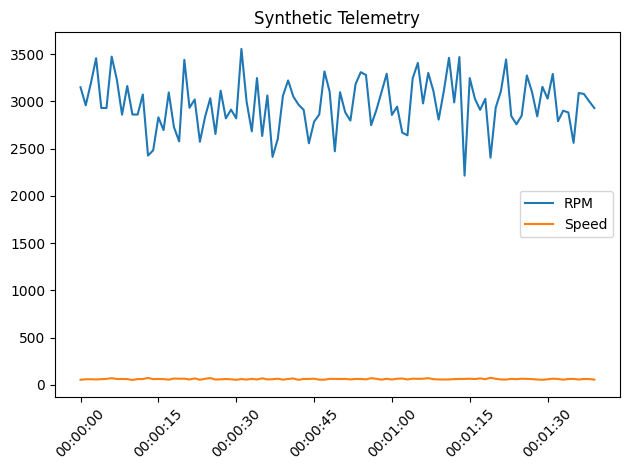

c:\Users\dev\Dropbox\ai_ml\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Import Libraries
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 2. Set Device
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Simulate Telemetry Data
# ─────────────────────────────────────────────────────────────────────────────
np.random.seed(42)
time_steps = 100

data = {
    "timestamp": pd.date_range("2025-01-01", periods=time_steps, freq="1s"),
    "rpm": np.random.normal(3000, 300, time_steps),
    "speed": np.random.normal(60, 5, time_steps),
    "gear": np.random.randint(1, 6, time_steps),
    "brake": np.random.choice([0, 1], time_steps, p=[0.9, 0.1]),
    "coolant_temp": np.random.normal(190, 5, time_steps),
    "throttle_pos": np.random.uniform(0, 100, time_steps)
}

df = pd.DataFrame(data)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Normalize Features and Split
# ─────────────────────────────────────────────────────────────────────────────
features = ["rpm", "speed", "gear", "brake", "coolant_temp", "throttle_pos"]
normalized = (df[features] - df[features].mean()) / df[features].std()

split_idx = int(0.8 * len(normalized))
train_norm = normalized.iloc[:split_idx]
val_norm = normalized.iloc[split_idx:]

# ─────────────────────────────────────────────────────────────────────────────
# 5. Positional Encoding for Train/Val
# ─────────────────────────────────────────────────────────────────────────────
T, D = normalized.shape
position_embedding_layer = nn.Embedding(T, D).to(device)

train_pos_ids = torch.arange(len(train_norm)).unsqueeze(1).to(device)
val_pos_ids = torch.arange(len(val_norm)).unsqueeze(1).to(device)
train_pos_emb = position_embedding_layer(train_pos_ids.squeeze())
val_pos_emb = position_embedding_layer(val_pos_ids.squeeze())

# ─────────────────────────────────────────────────────────────────────────────
# 6. Prepare Tensors for Model
# ─────────────────────────────────────────────────────────────────────────────
train_tensor = torch.tensor(train_norm.values, dtype=torch.float32).to(device)
val_tensor = torch.tensor(val_norm.values, dtype=torch.float32).to(device)
train_input = train_tensor + train_pos_emb
val_input = val_tensor + val_pos_emb

# ─────────────────────────────────────────────────────────────────────────────
# 7. Visualize a Sample
# ─────────────────────────────────────────────────────────────────────────────
print("Train input shape:", train_input.shape)
print("First few rows:\n", train_input[:5].cpu())

plt.plot(df["timestamp"], df["rpm"], label="RPM")
plt.plot(df["timestamp"], df["speed"], label="Speed")
plt.legend()
plt.title("Synthetic Telemetry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 8. Transformer Encoder Model
# ─────────────────────────────────────────────────────────────────────────────
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # (seq_len, 1, input_dim)
        x = self.transformer(x)
        x = x.squeeze(1)    # (seq_len, input_dim)
        return self.output_layer(x)

model = SimpleTransformerEncoder(
    input_dim=train_input.shape[1], nhead=2, num_layers=2, dim_feedforward=128
).to(device)



In [ ]:
class ImprovedTransformerEncoder(nn.Module):
    def __init__(self, input_dim, nhead=4, num_layers=3, dim_feedforward=256, dropout=0.1):
        super().__init__()
        # Input projection to increase representation power
        # What it does: Transforms your input features from their original dimension to a higher dimension.
        # Higher dimensions give the model more "space" to learn complex patterns
        # Acts as a learned feature extraction layer
        # Similar to how CNNs use more filters to capture more patterns
        # Initialization: At the start, the projection layer (self.input_projection) is 
        # initialized with random weights (thanks to the default PyTorch initialization)        #         
        self.input_projection = nn.Linear(input_dim, input_dim * 2)
        
        # Better positional encoding
        self.pos_encoder = nn.Parameter(torch.zeros(1000, input_dim * 2))
        nn.init.xavier_uniform_(self.pos_encoder)
        # Xavier initialization explained:

        # Neural networks need good initial weights to train effectively
        # Random weights that are too large → exploding gradients
        # Random weights that are too small → vanishing gradients
        # Xavier/Glorot initialization creates weights with variance based on layer size
        # This keeps signals properly scaled throughout the network
        # Result: Faster convergence and better performance        
        
        # More sophisticated transformer with dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim * 2, 
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Dropout explained:

        # During training, randomly "turns off" (sets to zero) a percentage of neurons
        # In this case, dropout=0.1 means 10% of values are zeroed out each forward pass
        # Forces the network to not rely too heavily on any single feature
        # Acts as regularization to prevent overfitting
        # Only active during training, not during inference

        self.transformer = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers,
            norm=nn.LayerNorm(input_dim * 2)
        )
        
        # Multi-layer decoder
        self.decoder = nn.Sequential(
            nn.Linear(input_dim * 2, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, input_dim)
        )
        
    def forward(self, x):
        # Project input to higher dimension
        # During Training:

        # Each forward pass uses the current weights to calculate projected values
        # The backward pass updates these weights via gradient descent
        # The projection gradually learns better feature combinations
        # After Training:

        # The weights have converged to values that create useful projections
        # These final weights transform the input features in ways that help anomaly detection        
        x = self.input_projection(x)
        
        # Add positional encoding
        seq_len = x.size(0)
        x = x + self.pos_encoder[:seq_len, :]
        
        # Reshape for transformer (batch_first=True)
        x = x.unsqueeze(1)  # (seq_len, 1, input_dim*2)
        
        # Pass through transformer
        x = self.transformer(x)
        x = x.squeeze(1)    # (seq_len, input_dim*2)
        
        # Decode to original dimension
        return self.decoder(x)

## Training loop
The second code cell trains the Transformer encoder to reconstruct its input. Mean squared error is used as the loss and both training and validation losses are plotted during training.

Epoch 1/300 - Train Loss: 2.0641 - Val Loss: 2.1457
Epoch 10/300 - Train Loss: 1.7734 - Val Loss: 1.8596
Epoch 20/300 - Train Loss: 1.5288 - Val Loss: 1.6081
Epoch 30/300 - Train Loss: 1.3201 - Val Loss: 1.3927
Epoch 40/300 - Train Loss: 1.1833 - Val Loss: 1.2287
Epoch 50/300 - Train Loss: 1.0384 - Val Loss: 1.0575
Epoch 60/300 - Train Loss: 0.8701 - Val Loss: 0.8955
Epoch 70/300 - Train Loss: 0.7396 - Val Loss: 0.7403
Epoch 80/300 - Train Loss: 0.5962 - Val Loss: 0.6181
Epoch 90/300 - Train Loss: 0.5115 - Val Loss: 0.5140
Epoch 100/300 - Train Loss: 0.4471 - Val Loss: 0.4297
Epoch 110/300 - Train Loss: 0.3588 - Val Loss: 0.3575
Epoch 120/300 - Train Loss: 0.3344 - Val Loss: 0.3122
Epoch 130/300 - Train Loss: 0.2970 - Val Loss: 0.2699
Epoch 140/300 - Train Loss: 0.2851 - Val Loss: 0.2529
Epoch 150/300 - Train Loss: 0.2535 - Val Loss: 0.2375
Epoch 160/300 - Train Loss: 0.2708 - Val Loss: 0.2281
Epoch 170/300 - Train Loss: 0.2448 - Val Loss: 0.2217
Epoch 180/300 - Train Loss: 0.2366 - Va

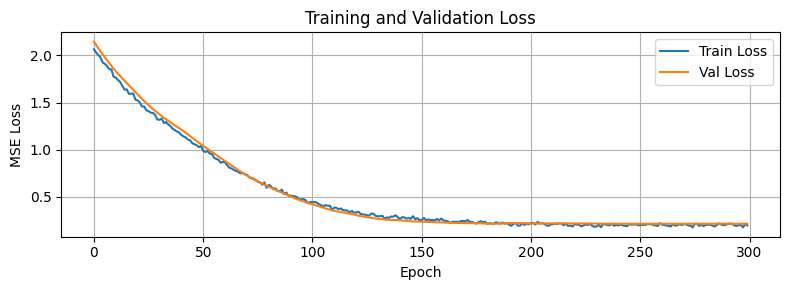

In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# 9. Train the Transformer Encoder Model (with CUDA support)
# ─────────────────────────────────────────────────────────────────────────────

# Clear CUDA cache first
if torch.cuda.is_available():
    torch.cuda.empty_cache()

epochs = 300
learning_rate = 1e-3
criterion = nn.MSELoss()
# model = SimpleTransformerEncoder(
#     input_dim=train_input.shape[1], nhead=2, num_layers=2, dim_feedforward=128
# ).to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Model instantiation with better parameters
model = ImprovedTransformerEncoder(
    input_dim=train_input.shape[1], 
    nhead=4,                # More attention heads
    num_layers=3,           # More transformer layers
    dim_feedforward=256,    # Wider feedforward networks
    dropout=0.1             # Add regularization
).to(device)

# Learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Create fresh copies of input tensors to avoid graph issues
train_input_copy = train_input.clone().detach()
val_input_copy = val_input.clone().detach()

train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_input_copy)
    loss = criterion(output, train_input_copy)
    loss.backward()

    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(val_input_copy)
        val_loss = criterion(val_output, val_input_copy)

    # Store the losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

plt.figure(figsize=(8, 3))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



## Scoring anomalies
After training, the model runs on the full sequence. The per time-step reconstruction error becomes the anomaly score, which is visualised to highlight unusual behaviour in the synthetic telemetry.

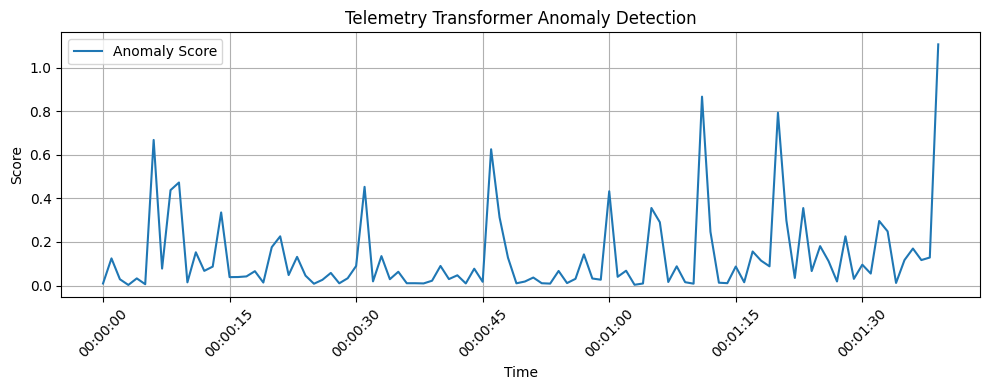

In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# 10. Forward Pass and Anomaly Score Calculation (on all data)
# ─────────────────────────────────────────────────────────────────────────────
# Rebuild full positional embeddings for all data
position_ids = torch.arange(T).unsqueeze(1).to(device)
position_embeddings = position_embedding_layer(position_ids.squeeze())
inputs = torch.tensor(normalized.values, dtype=torch.float32).to(device)
transformer_input = inputs + position_embeddings

model.eval()
with torch.no_grad():
    reconstructed = model(transformer_input)

loss_per_timestep = F.mse_loss(reconstructed, transformer_input, reduction='none').mean(dim=1)
anomaly_scores = loss_per_timestep.detach().cpu().numpy()
df["anomaly_score"] = anomaly_scores

# ─────────────────────────────────────────────────────────────────────────────
# 11. Visualize Results
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["anomaly_score"], label="Anomaly Score")
plt.title("Telemetry Transformer Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## Analysing feature contributions
The final code cell looks at how each telemetry feature contributes to the anomaly score. Reconstruction errors are examined feature by feature and visualisations show which signals have the largest effect for the most anomalous points.

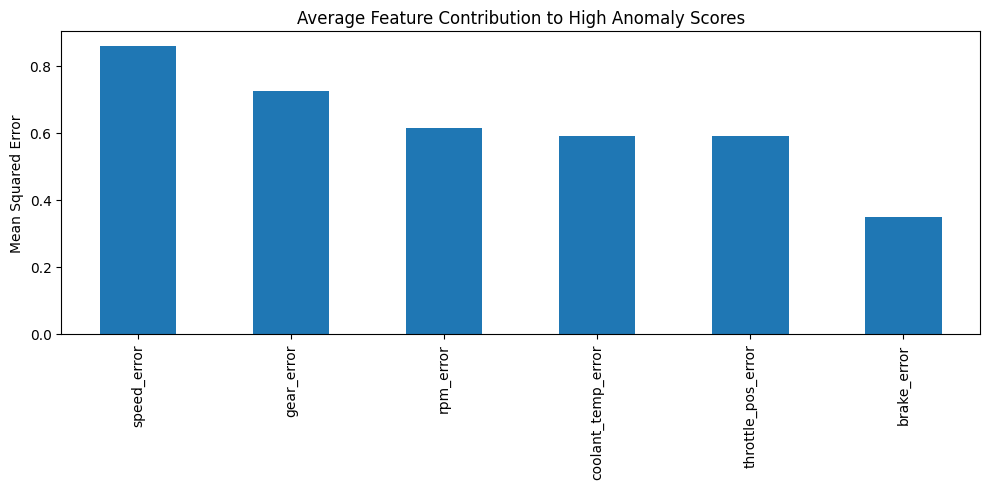

Top 3 anomaly points and their feature errors:
    rpm_error  speed_error  gear_error  brake_error  coolant_temp_error  \
99   0.062807     3.358762    1.682895     0.034394            1.494294   
71   0.229535     1.921702    2.110134     0.006864            0.003616   
80   0.132233     0.637522    0.991320     0.223828            2.187221   

    throttle_pos_error           timestamp  anomaly_score  
99            0.007123 2025-01-01 00:01:39       1.106713  
71            0.928693 2025-01-01 00:01:11       0.866758  
80            0.587234 2025-01-01 00:01:20       0.793226  


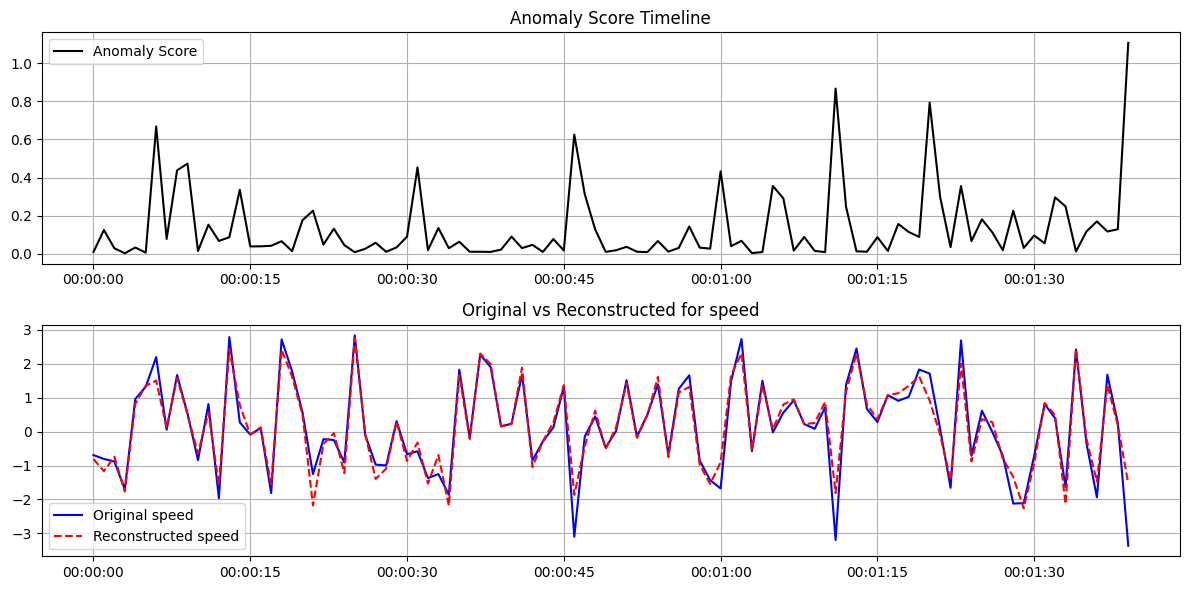

In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# 12. Feature-Level Contribution Analysis
# ─────────────────────────────────────────────────────────────────────────────
# Calculate per-feature reconstruction errors
feature_errors = F.mse_loss(reconstructed, transformer_input, reduction='none').detach().cpu().numpy()

# Create DataFrame with per-feature errors
error_df = pd.DataFrame(feature_errors, columns=[f"{col}_error" for col in features])
error_df["timestamp"] = df["timestamp"]
error_df["anomaly_score"] = df["anomaly_score"]

# Find top anomaly points (e.g., top 10% of scores)
threshold = np.percentile(df["anomaly_score"], 90)
high_anomaly_points = error_df[error_df["anomaly_score"] > threshold]

# Calculate average contribution of each feature to high anomaly scores
feature_contribution = high_anomaly_points[[f"{col}_error" for col in features]].mean()
feature_contribution = feature_contribution.sort_values(ascending=False)

# Visualize feature contributions
plt.figure(figsize=(10, 5))
feature_contribution.plot(kind='bar')
plt.title("Average Feature Contribution to High Anomaly Scores")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.show()

# Visualize the features with highest contribution for top 3 anomalies
top_anomalies = error_df.nlargest(3, "anomaly_score")
print("Top 3 anomaly points and their feature errors:")
print(top_anomalies)

# Plot original vs. reconstructed for highest contributor feature
highest_contrib_feature = feature_contribution.index[0].replace("_error", "")
highest_idx = features.index(highest_contrib_feature)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df["timestamp"], df["anomaly_score"], 'k-', label="Anomaly Score")
plt.title("Anomaly Score Timeline")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
original = transformer_input.detach().cpu().numpy()[:, highest_idx]
reconstructed_np = reconstructed.detach().cpu().numpy()[:, highest_idx]
plt.plot(df["timestamp"], original, 'b-', label=f"Original {highest_contrib_feature}")
plt.plot(df["timestamp"], reconstructed_np, 'r--', label=f"Reconstructed {highest_contrib_feature}")
plt.title(f"Original vs Reconstructed for {highest_contrib_feature}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 13. Artificial Anomaly Injection and Detection
# ─────────────────────────────────────────────────────────────────────────────
import copy

def inject_anomalies(df_original, normalized_original):
    """Inject different types of anomalies into a copy of the original data."""
    # Make deep copies to avoid modifying originals
    df = df_original.copy()
    normalized = normalized_original.copy()
    
    # Dictionary to track injected anomalies
    anomalies = {
        'point': [],  # Sudden spikes
        'contextual': [],  # Values normal globally but unusual in context
        'collective': []   # Multiple features changing together
    }
    
    # 1. Point anomaly: Sudden spike in RPM at a specific timestamp
    point_idx = 30
    df.loc[point_idx, 'rpm'] = df['rpm'].mean() + df['rpm'].std() * 5  # 5 std dev spike
    normalized.loc[point_idx, 'rpm'] = (df.loc[point_idx, 'rpm'] - df['rpm'].mean()) / df['rpm'].std()
    anomalies['point'].append(point_idx)
    
    # 2. Contextual anomaly: Unusual speed for the current RPM
    context_idx = 50
    df.loc[context_idx, 'speed'] = df['speed'].mean() * 0.3  # Very low speed
    normalized.loc[context_idx, 'speed'] = (df.loc[context_idx, 'speed'] - df['speed'].mean()) / df['speed'].std()
    anomalies['contextual'].append(context_idx)
    
    # 3. Collective anomaly: Unusual pattern across multiple features
    # High rpm but low speed and high brake (car revving while braking)
    collective_start = 70
    collective_end = 75
    for i in range(collective_start, collective_end):
        df.loc[i, 'rpm'] = df['rpm'].mean() * 1.5  # High RPM
        df.loc[i, 'speed'] = df['speed'].mean() * 0.6  # Low speed
        df.loc[i, 'brake'] = 1  # Brake engaged
        
        # Normalize the modified values
        for col in ['rpm', 'speed', 'brake']:
            normalized.loc[i, col] = (df.loc[i, col] - df[col].mean()) / df[col].std()
        
    anomalies['collective'].extend(list(range(collective_start, collective_end)))
    
    print(f"Injected anomalies at indices: {anomalies}")
    return df, normalized, anomalies